In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Regression models

First let's load in the data. Here you can load in any ``.csv`` version of our data, but the comments and discussions in this notebook refer to what happens when running this notebook using `bikeshare_train_data_pcwsdetrend_mult.csv` (and its testing set analogue).

In [2]:
bikeshare = pd.read_csv('../EDA/bikeshare_train_data_pcwsdetrend_mult.csv', parse_dates=['Date'],index_col=['Date'])
bikeshare_test = pd.read_csv('../EDA/bikeshare_test_data_pcwsdetrend_mult.csv', parse_dates=['Date'],index_col=['Date'])

In [3]:
bikeshare.sample(5)

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,...,max_gust,mean_dep_temp,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,adj_num_trips,trend_val
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-08,588.150000,2.9,8.0,5.5,5.1,12.5,0.0,2.9,0.0,2.9,...,0.0,8.829296,9.782007,9.305652,1968435.00,856710.0,0.0,867,662.250514,1.309172
2018-09-19,741.200000,7.9,19.3,13.6,11.4,4.4,0.0,1.0,0.0,1.0,...,0.0,18.832704,19.342494,19.087599,7469287.01,3030024.0,0.0,2911,2394.617511,1.215643
2021-07-22,933.250000,12.8,21.7,17.3,8.9,0.7,0.0,0.0,0.0,0.0,...,0.0,24.902302,24.932816,24.917559,10989973.67,4870751.0,0.0,3736,3445.861577,1.084199
2020-04-08,801.216667,1.3,12.7,7.0,11.4,11.0,0.0,0.0,0.0,0.0,...,0.0,15.791805,16.036545,15.914175,3104963.00,3174341.0,0.0,903,1617.866562,0.558142
2020-02-24,641.166667,4.1,7.7,5.9,3.6,12.1,0.0,1.2,0.0,1.2,...,23.0,8.907357,9.695913,9.301635,4307581.34,2189008.0,0.0,1835,1427.606151,1.285369


Recall that the features are defined as:

- ``day_length``: The number of minutes from sunrise to sunset for the given day
- ``min_temp``: The daily minimum temperature (deg C)
- ``max_temp``: The daily maximum temperature (deg C)
- ``mean_temp``: The mean temperature of the day (deg C)
- ``temp_diff``: The difference between the daily minimum and maximum temperatures (deg C)
- ``hdd``: The "Heating Degree Days" of the day, the number of degrees C that the daily average temperature is below 18 degrees C (0 if the daily average temperature is above 18 degrees C)
- ``cdd``: The "Cooling Degree Days" of the day, the number of degrees C that the daily average temperature is above 18 degrees C (0 if the daily average temperature is below 18 degrees C)
- ``rain``: The amount of rain that occurred that day (mm)
- ``snow``: The amount of snow that occurred that day (cm)
- ``total_precip``: The total amount of rain and snow that occurred that day (mm) (Note: the standard conversion of snow-to-rain amount is a factor of ten, so 1cm of snow is equivalent to 1mm of rain; therefore, this column is exactly the sum of ``rain`` and ``snow``)
- ``snow_on_ground``: The amount of snow observed on the ground during the day (cm)
- ``max_gust``: The difference between the speed of the observed maximum gust of wind (in km/hr) and 31 km/hr (0 if the maximum observed gust of wind is at or below 31 km/hr)
- ``mean_dep_temp``: The mean departure temperature of all bike rides taken that day (deg C)
- ``mean_ret_temp``: The mean return temperature of all bike rides taken that day (deg C)
- ``total_dist``: The total distance covered by all bike rides taken that day (m)
- ``total_duration``: The total time spent on bikes that day (sec)
- ``ebike_trips``: The number of bike rides taken on electric bikes that day
- ``num_trips`` The total number of bike rides taken that day, regardless of bicycle type
- In the notebook ``EDA.ipynb`` we added another column, ``adj_num_trips``, that are the number of trips with a certain baseline bikeshare demand removed. In other notebooks in the ``EDA`` folder we produced different de-trended versions of ``adj_num_trips``. Depending on the file loaded in above, ``adj_num_trips`` is some adjusted number of bike rides for a particular de-trending. (If there are any additional columns, they are for predicting ``num_trips`` from ``adj_num_trips``.)

We aim to predict this adjusted number of trips, and then later convert these into actual predicted ``num_trips``.

In ``EDA.ipynb`` we used correlation matrices, plots, and lasso regression to perform some feature selection and handle some collinearity issues between columns. As such the features we will focus on in this notebook are
- ``day_length``,
- ``max_temp``,
- ``temp_diff``,
- ``total_precip``,
- ``snow_on_ground``, and
- ``max_gust``.

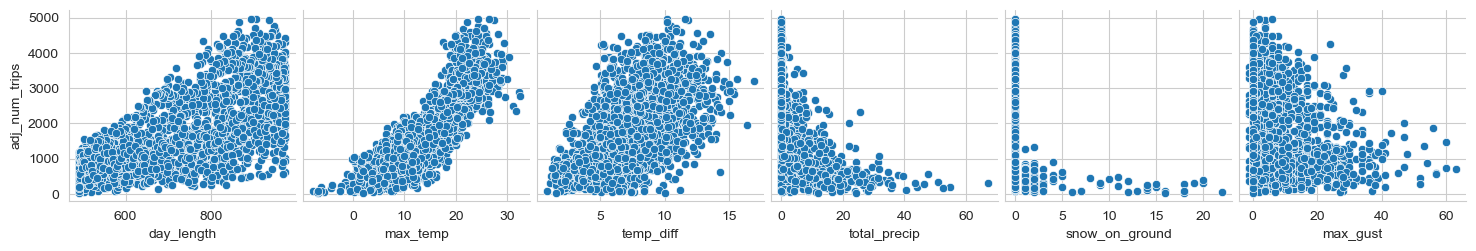

In [4]:
features = ['day_length','max_temp','temp_diff','total_precip','snow_on_ground','max_gust']
##Target variable name, this should be a column of the bikeshare-weather data csv that has a version of detrending applied to it
target = 'adj_num_trips'
sns.pairplot(data=bikeshare,
             x_vars=features,
            y_vars=[target])

plt.show()

Some initial thoughts:
- ``max_temp`` probably depends on ``day_length`` in some way so we should probably include an interaction term for these two features,
- Much of ``snow_on_ground`` is zero (and when nonzero has a pretty "small" distribution of values) so including or excluding this term in a model likely won't affect performance much, and
- ``max_gust`` and ``temp_diff`` look too scattered that it's possible they don't make it into the final model.

In any case, we only have six features under consideration. We can perform best subsets selection on these six features and then if some of the higher-performing subsets include ``day_length`` and ``max_temp`` we can compare those models' performances to one including an interaction term (we could do this in the other order--i.e., including the interaction, doing best subsets selection, then throwing away models that include the interaction term but not both the others, but our way has a shorter runtime).

In [5]:
# This returns the power set of a set minus the empty set. (Copied from a lecture notebook from this bootcamp)
# Credit to Erdős alumni Nadir Hajouji for greatly simplifying this function!

def powerset(s):
    power_set = [[]]
    for x in s:
        power_set += [s0+[x] for s0 in power_set]
    return power_set[1:]

In [6]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [7]:
n_splits = 5
kfold = KFold(n_splits,
              shuffle=True,
              random_state=604)

In [8]:
scaler = StandardScaler().set_output(transform='pandas')
bikeshare_scaled = scaler.fit_transform(bikeshare[features])
bikeshare_scaled[target] = bikeshare[target]

Before we look at best subsets let us look at just the mean ``adj_num_trips`` and its RMSE for a baseline to compare to; at this stage our only comparison is the base demand trend from ``EDA.ipynb``.

In [9]:
avg_num_trips = bikeshare[target].mean()
baseline_rmse = np.sqrt(mean_squared_error(bikeshare[target], np.ones(len(bikeshare))*avg_num_trips))
print("Using the average number of detrended trips as a constant prediction has a RMSE of", baseline_rmse)

Using the average number of detrended trips as a constant prediction has a RMSE of 1081.1177329548495


In [10]:
models = powerset(features)
rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

In [11]:
avg_rmses = np.mean(rmses, axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[ 756.09340511  549.33248367  545.62051631  883.72230084  674.08456433
  522.3942818   518.31918052  969.95751732  699.74926399  474.23648297
  473.62063176  851.46619726  651.03332925  468.67237832  467.75569648
 1063.90259863  751.0893422   548.56032775  545.08433633  869.78866759
  668.66451243  522.21692857  518.28510183  959.04890129  696.77640168
  472.97320362  472.49714239  840.11593732  646.80456522  467.89171495
  467.14209331 1054.1317752   744.175723    535.09623803  532.13331695
  878.46145954  670.95414367  514.40607795  510.99878671  963.71429509
  697.21663712  471.35339275  470.8016644   850.33487643  650.59453914
  466.6804389   465.86061135 1035.88167884  738.61911347  534.38952333
  531.6345234   864.1500849   665.3152485   514.17946613  510.90924192
  951.89514731  693.83319826  470.06002619  469.64382621  838.58755907
  646.1866191   465.82598921  465.16816801]
The models have average cross-validation RMSEs ranging from 465.1681680110137 to 1063.9025986271474
The 

That's all the features (although we can see that there are certain other models that also perform similarly that use subsets of these features). Let's compare this performance to best subsets where all models include ``day_length``, ``max_temp``, and an interaction term between them:

In [12]:
bikeshare_scaled['day_length_x_max_temp'] = bikeshare_scaled.day_length * bikeshare_scaled.max_temp

In [13]:
base_features = ['day_length','max_temp','day_length_x_max_temp']
remaining_features = ['temp_diff', 'total_precip', 'snow_on_ground', 'max_gust']
models = [base_features + subset for subset in powerset(remaining_features)]

rmses = np.zeros((n_splits,len(models)))

for i, (train_index, test_index) in enumerate(kfold.split(bikeshare_scaled)):
    bike_tt = bikeshare_scaled.iloc[train_index]
    bike_ho = bikeshare_scaled.iloc[test_index]

    for j, model in enumerate(models):
        reg = LinearRegression()
        reg.fit(bike_tt[model], bike_tt[target])
        pred = reg.predict(bike_ho[model])

        rmses[i,j] = np.sqrt(mean_squared_error(bike_ho[target], pred))

avg_rmses = np.mean(rmses,axis=0)
print(avg_rmses)
print("The models have average cross-validation RMSEs ranging from",np.min(avg_rmses),"to",np.max(avg_rmses))
print("The model with the minimum average cross-validation RMSE of",np.min(avg_rmses),"uses the features",models[np.argmin(avg_rmses)])

[506.47427384 462.5560389  457.66496942 530.72060894 506.37503816
 462.82929321 458.01090251 520.35995929 501.04777073 460.82192721
 456.58861826 520.35406918 500.94319585 460.98852438 456.84498001]
The models have average cross-validation RMSEs ranging from 456.58861825895553 to 530.7206089386095
The model with the minimum average cross-validation RMSE of 456.58861825895553 uses the features ['day_length', 'max_temp', 'day_length_x_max_temp', 'temp_diff', 'total_precip', 'max_gust']


In [14]:
best_subset = models[np.argmin(avg_rmses)]
best_subset

['day_length',
 'max_temp',
 'day_length_x_max_temp',
 'temp_diff',
 'total_precip',
 'max_gust']

# Performance Visualization

The best-performing linear regression for ``adj_num_trips`` occurs on the features listed above.

Let's look at a plot with these predictions on the daily timescale.

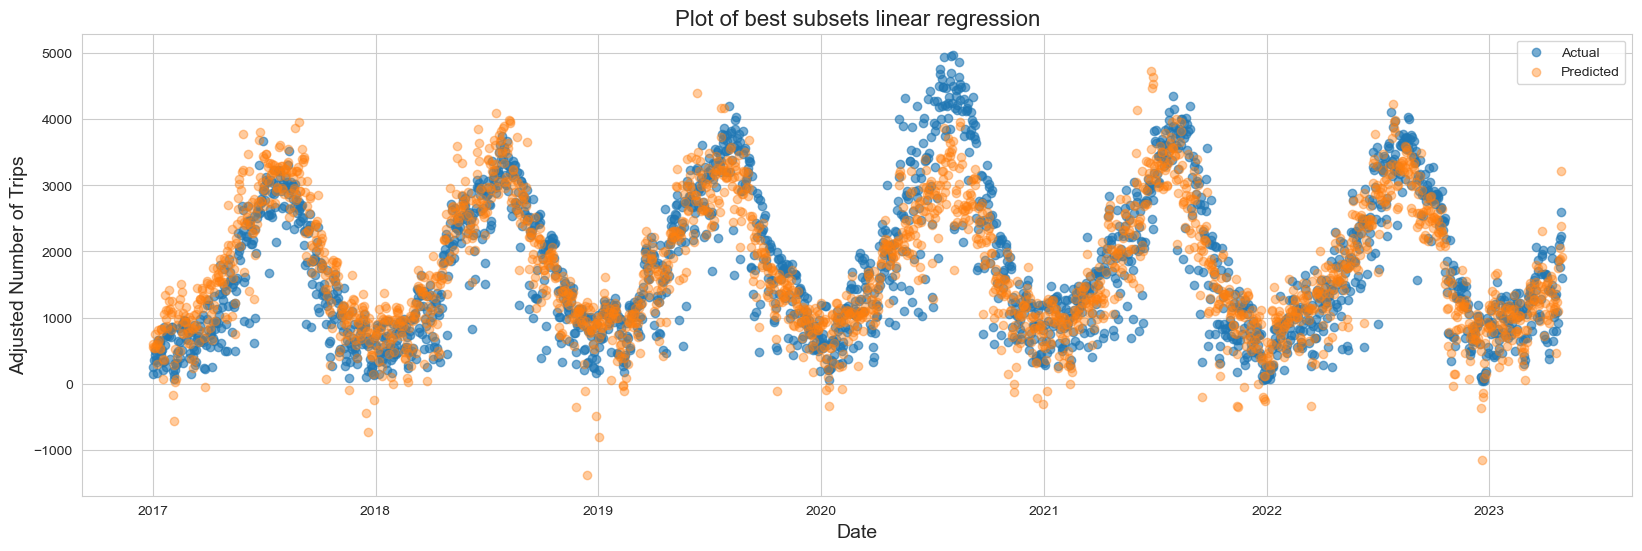

In [15]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare[target],
           alpha=0.6,
           label='Actual')

reg_bestsubset = LinearRegression()
reg_bestsubset.fit(bikeshare_scaled[best_subset],
                   bikeshare[target])
preds_bestsubset = reg_bestsubset.predict(bikeshare_scaled[best_subset])

plt.scatter(bikeshare.index.values,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression',fontsize=16)
plt.legend()

plt.show()

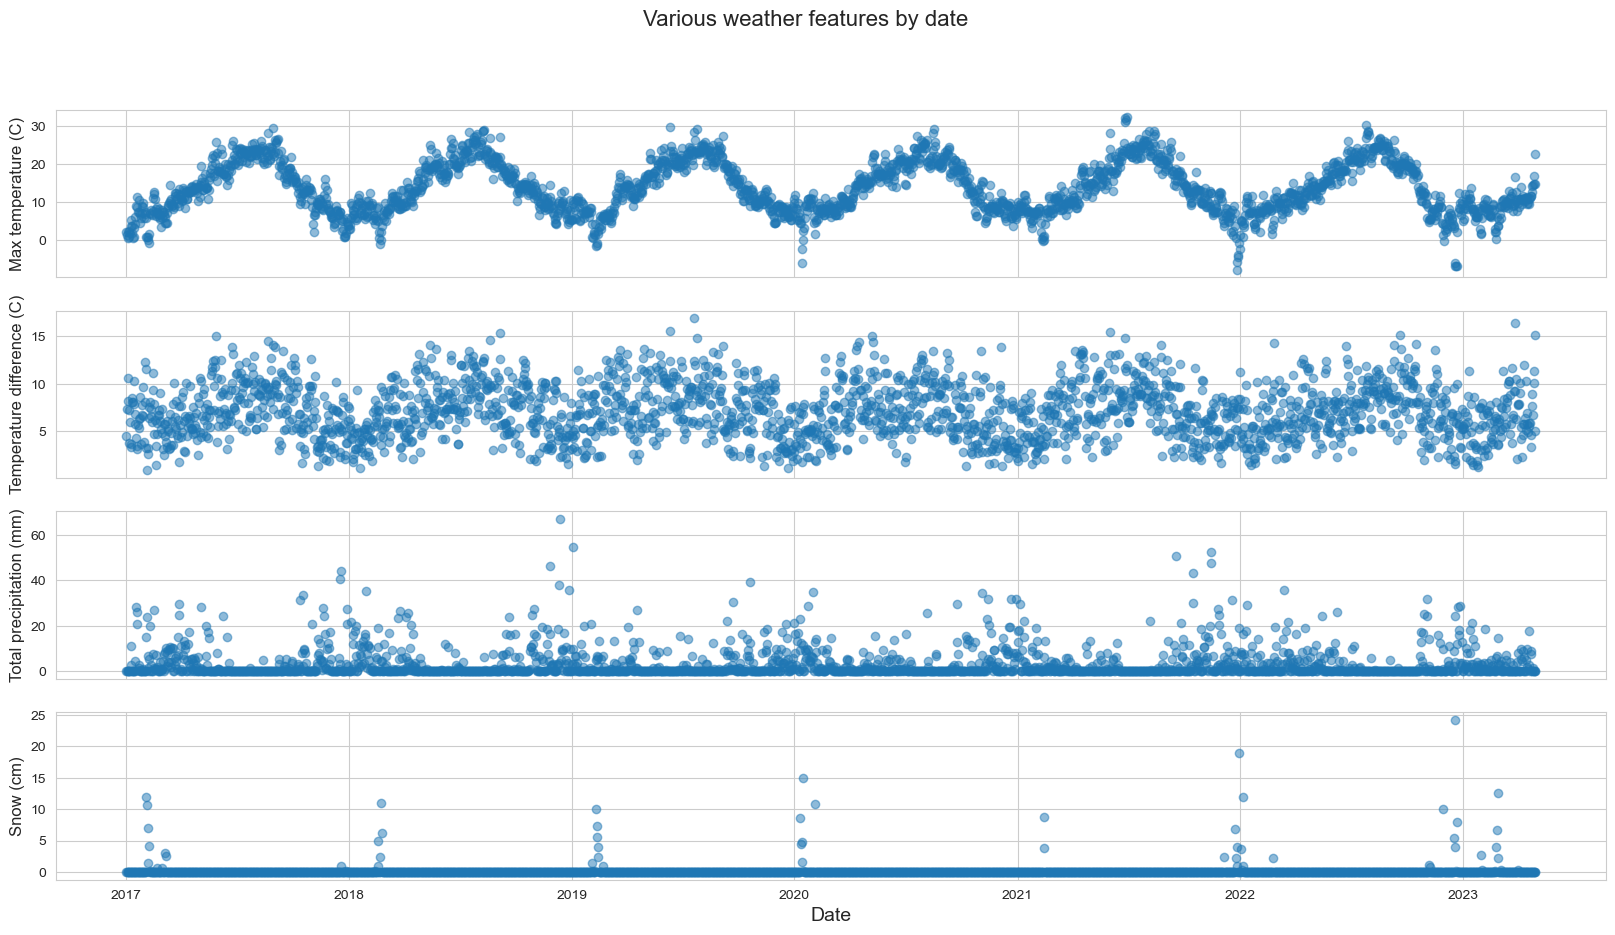

In [16]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex = True, figsize=(20,10))

plt.suptitle('Various weather features by date',fontsize=16)

ax[0].scatter(bikeshare.index,
           bikeshare.max_temp,
           alpha=0.5)
ax[0].set_ylabel('Max temperature (C)', fontsize=12)

ax[1].scatter(bikeshare.index,
           bikeshare.temp_diff,
           alpha=0.5)
ax[1].set_ylabel('Temperature difference (C)',fontsize=12)

ax[2].scatter(bikeshare.index,
           bikeshare.total_precip,
           alpha=0.5)
ax[2].set_ylabel('Total precipitation (mm)',fontsize=12)

ax[3].scatter(bikeshare.index,
           bikeshare.snow,
           alpha=0.5)
ax[3].set_ylabel('Snow (cm)',fontsize=12)

plt.xlabel('Date', fontsize=14)

plt.show()

As we can see, a lot of our error is concentrated in mid-2020, and the weather patterns from mid-2020 are not much different than other years. Thus this error is due to either factors unseen by the data or an inaccuracy in our trend forecasting (likely the latter).

Lastly a plot of residuals:

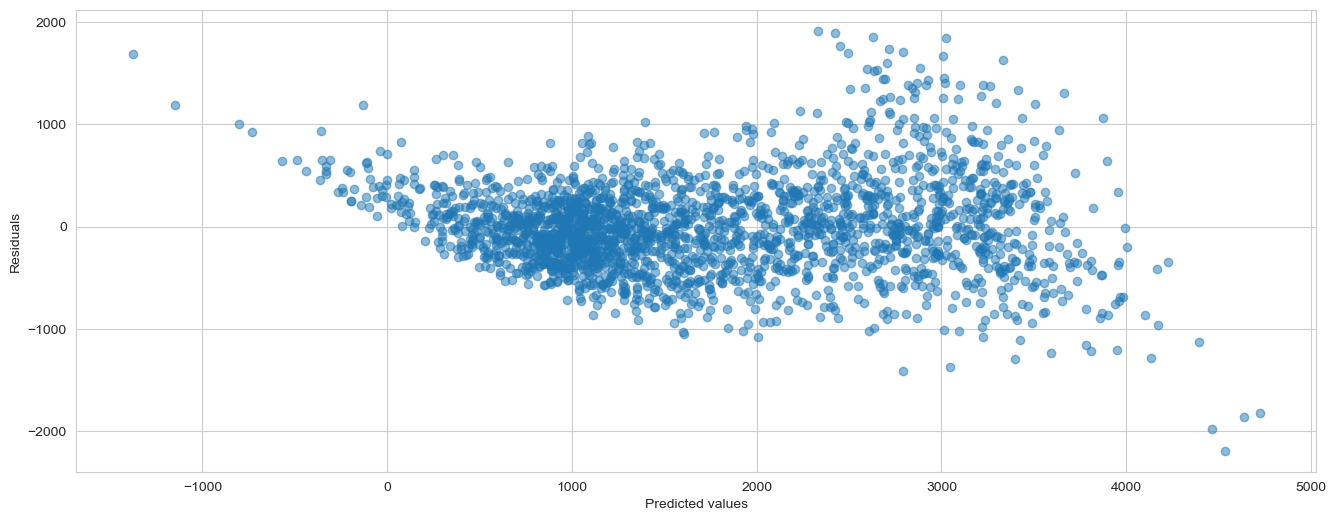

In [17]:
residuals = bikeshare[target] - preds_bestsubset

plt.figure(figsize=(16,6))

plt.scatter(preds_bestsubset,
           residuals,
           alpha=0.5)

plt.xlabel('Predicted values')
plt.ylabel('Residuals')

plt.show()

Once again, the residuals grow as the predicted value grows. While undesirable we can see that most of the predicted values around 3000 occur during summer months, and summer 2020 contains our largest residuals.

# Performance on Test Data

First apply the transformations made in this notebook to the test data, and make a prediction for the target variable:

In [18]:
bikeshare_test_scaled = scaler.transform(bikeshare_test[features])
bikeshare_test_scaled[target] = bikeshare_test[target]

bikeshare_test_scaled['day_length_x_max_temp'] = bikeshare_test_scaled.day_length * bikeshare_test_scaled.max_temp

test_preds = reg_bestsubset.predict(bikeshare_test_scaled[best_subset])

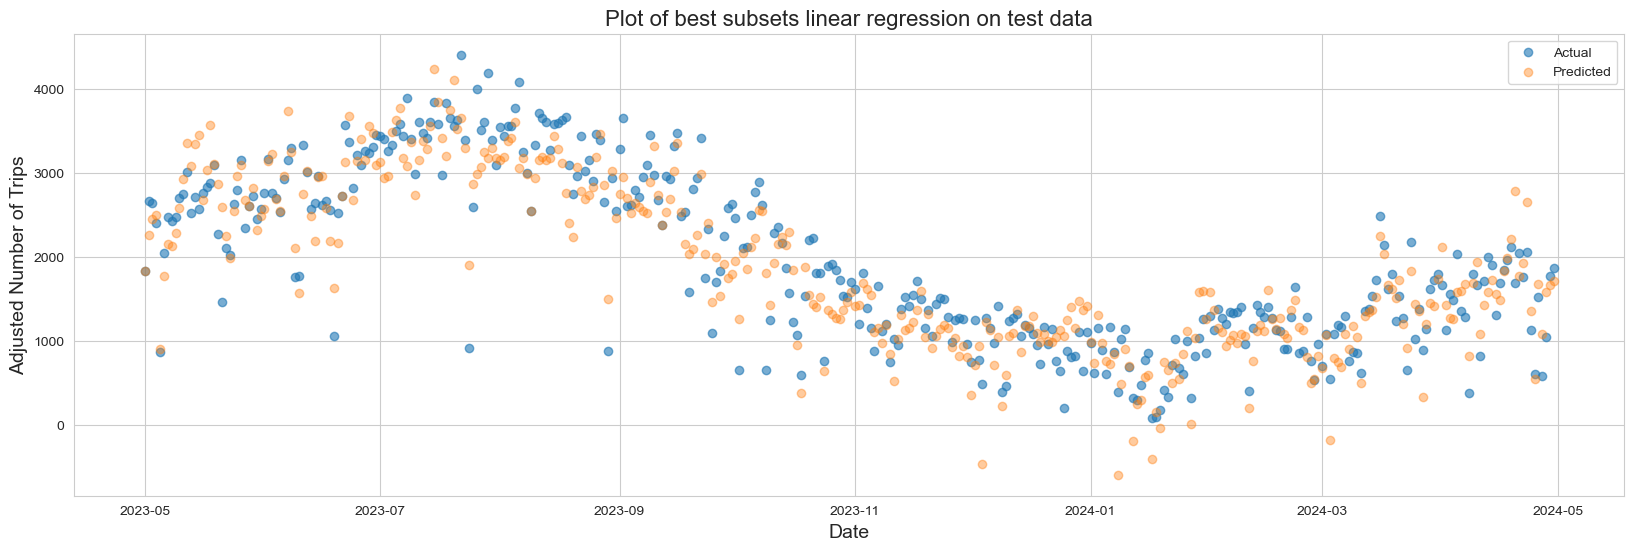

In [19]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare_test.index,
           bikeshare_test[target],
           alpha=0.6,
           label='Actual')

plt.scatter(bikeshare_test.index.values,
           test_preds,
           alpha=0.4,
           label='Predicted')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on test data',fontsize=16)
plt.legend()

plt.show()

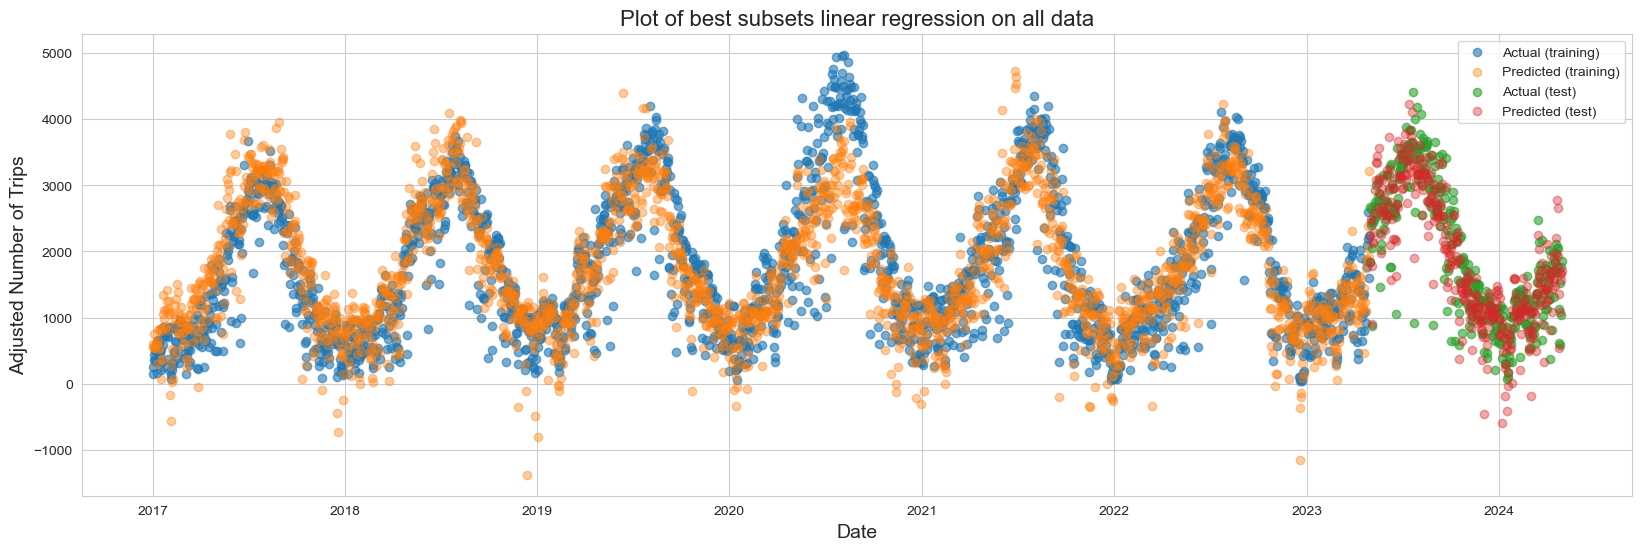

In [20]:
plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare[target],
           alpha=0.6,
           label='Actual (training)')

plt.scatter(bikeshare.index.values,
           preds_bestsubset,
           alpha=0.4,
           label='Predicted (training)')

plt.scatter(bikeshare_test.index,
           bikeshare_test[target],
           alpha=0.6,
           label='Actual (test)')

plt.scatter(bikeshare_test.index.values,
           test_preds,
           alpha=0.4,
           label='Predicted (test)')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Adjusted Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on all data',fontsize=16)
plt.legend()

plt.show()

In [21]:
print("The RMSE for predicting adj_num_trips on the training data is",np.sqrt(mean_squared_error(bikeshare.adj_num_trips, preds_bestsubset)))
print("The RMSE for predicting adj_num_trips on the test data is",np.sqrt(mean_squared_error(bikeshare_test.adj_num_trips, test_preds)))

The RMSE for predicting adj_num_trips on the training data is 455.7562274284897
The RMSE for predicting adj_num_trips on the test data is 366.0609310955177


# Predicting ``num_trips`` from ``adj_num_trips`` and ``trend_val``

### [Note: This last plot only works for ``bikeshare_test_data_pcwstrend_mult.csv``. Add a ``trend_val`` column to the detrended data that can be used to recover `num_trips` from `adj_num_trips` to run this section.]

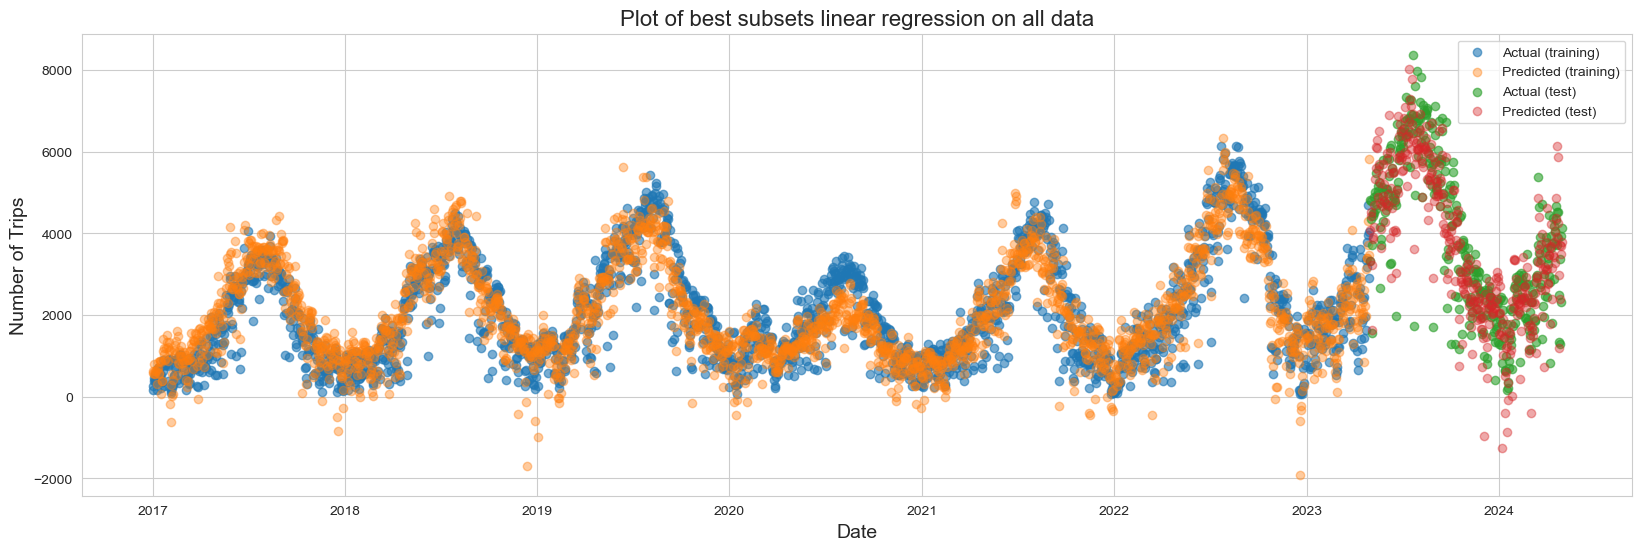

In [22]:
pred_num_trips_train = preds_bestsubset * bikeshare['trend_val']
pred_num_trips_test = test_preds * bikeshare_test['trend_val']

plt.figure(figsize=(20,6))

plt.scatter(bikeshare.index,
           bikeshare.num_trips,
           alpha=0.6,
           label='Actual (training)')

plt.scatter(bikeshare.index.values,
           pred_num_trips_train,
           alpha=0.4,
           label='Predicted (training)')

plt.scatter(bikeshare_test.index,
           bikeshare_test.num_trips,
           alpha=0.6,
           label='Actual (test)')

plt.scatter(bikeshare_test.index.values,
           pred_num_trips_test,
           alpha=0.4,
           label='Predicted (test)')

plt.xlabel('Date',fontsize=14)
plt.ylabel('Number of Trips',fontsize=14)
plt.title('Plot of best subsets linear regression on all data',fontsize=16)
plt.legend()

plt.show()

In [23]:
train_rmse = np.sqrt(mean_squared_error(bikeshare.num_trips,pred_num_trips_train))
test_rmse = np.sqrt(mean_squared_error(bikeshare_test.num_trips,pred_num_trips_test))

In [24]:
print("The RMSE for predicting num_trips on the training data is",train_rmse)
print("The RMSE for predicting num_trips on the test data is",test_rmse)

The RMSE for predicting num_trips on the training data is 495.408536695072
The RMSE for predicting num_trips on the test data is 730.799700085758
